# Coding of 3D-GCN -- Classification

## Preparing the environment

###Install packages

In [ ]:
import os
path = '/content/drive/MyDrive/3dgcn'
os.chdir(path)

In [ ]:
!pip3 install -r requirements.txt

###Download ModelNet40 dataset and downsample point cloud

In [ ]:
path = '/content/drive/MyDrive/3dgcn/classification'
os.chdir(path)

In [ ]:
!bash download.sh  #download ModelNet40 dataset

In [ ]:
!python3 sample_points.py -source ModelNet40 -target ModelNet40_1024_points -point_num 1024 #downsample the point cloud number to 1024

## Results replication

### Train the model, hyper-parameters needs to be edited
Use bash or command to train the model.

The training results are saved in '`record_gcn3d/pointnet/dgcnn/basecnn.log`'


In [ ]:
!bash train.sh  # train the model, set parameters
# !python main.py -model gcn3d
# !python main.py -model point -normal

### Test the model, hyper-parameters needs to be edited
Use bash or command to test the model.

The testing results are saved in '`shift/test/rotate.log`'

In [ ]:
!bash test.sh  # test the model, set parameters
# !python main.py -mode test -shift 10.0
# !python main.py -mode test -scale 5.0

### Our replicated results (gcn3d, pointnet, dgcnn)

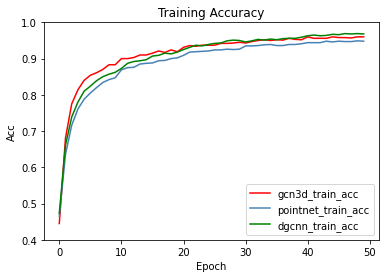

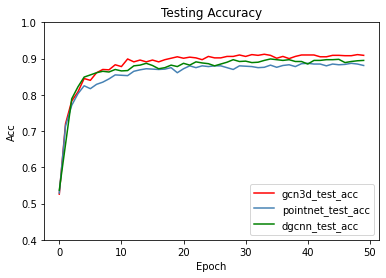

In [ ]:
import matplotlib.pyplot as plt
import re

model_trian_acc = []
model_test_acc = []

def Get_acc(model = 'gcn3d'):
  logFile = r'/content/drive/MyDrive/3dgcn/classification/record_' + model + '.log'
  text = ''
  file = open(logFile)
  for line in file:
      text += line
  file.close()

  train_loss_str = re.findall('= Epoch .*Tain Loss:\s(.*)\sTrain Acc.*',text)
  train_loss = [float(x) for x in train_loss_str]
  train_acc_str = re.findall('= Epoch .*Train Acc:\s(.*)\s\|\sTest Loss.*',text)
  train_acc = [float(x) for x in train_acc_str]
  test_loss_str = re.findall('= Epoch .*Test Loss:\s(.*)\sTest Acc.*',text)
  test_loss = [float(x) for x in test_loss_str]
  test_acc_str = re.findall('= Epoch .*Test Acc:\s(.*)\s\|\sBest Acc.*',text)
  test_acc = [float(x) for x in test_acc_str]

  model_trian_acc.append(train_acc)
  model_test_acc.append(test_acc)

models = ['gcn3d', 'pointnet', 'dgcnn']
for m in models:
  Get_acc(m)

plt.figure()
plt.title('Training Accuracy')
colors = ['red', 'steelblue', 'green']
for i in range(len(models)):
  plt.plot(model_trian_acc[i], label= models[i]+'_train_acc', c=colors[i])
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.ylim(0.4,1.0,0.1)
plt.legend(loc='lower right')
plt.show()

plt.title('Testing Accuracy')
for i in range(len(models)):
  plt.plot(model_test_acc[i], label= models[i]+'_test_acc', c=colors[i])
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.ylim(0.4,1.0,0.1)
plt.legend(loc='lower right')
plt.show()

### Our replicated results of valuation of invariance properties

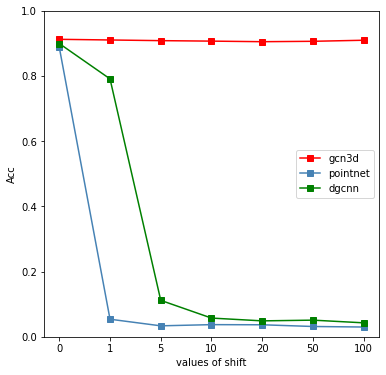

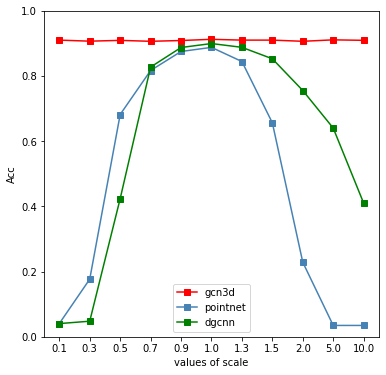

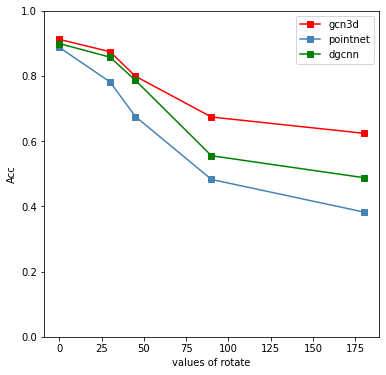

In [ ]:
from matplotlib.pyplot import MultipleLocator
def Get_pro(prop = 'shift'):
  logFile = r'/content/drive/MyDrive/3dgcn/classification/' + prop + '.log'
  text = ''
  file = open(logFile)
  for line in file:
      text += line
  file.close()

  prop_y = []
  for i in range(len(models)):
    y_str = re.findall('\d+.*\s'+ models[i] + '\s+(0.\d*)\s',text)
    y = [float(i) for i in y_str]
    prop_y.append(y)

  if(prop == 'shift'):
    prop_x = range(0,7)
    prop_x_index = [0, 1, 5, 10, 20, 50, 100]
  elif(prop == 'scale'):
    prop_x = range(0,11)
    prop_x_index = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 2.0, 5.0, 10.0]
  elif(prop == 'rotate'):
    x_str = re.findall('(\d+.\d*)\s+'+ models[0],text)
    prop_x = [float(i) for i in x_str]

  plt.figure(figsize=(6, 6))
  # plt.title(prop)
  colors = ['red', 'steelblue', 'green']
  for i in range(len(models)):
    plt.plot(prop_x, prop_y[i], label=models[i], c=colors[i], marker='s')
  plt.xlabel('values of '+ prop)
  plt.ylabel('Acc')
  plt.ylim(0,1,0.2)
  if(prop != 'rotate'):
    plt.xticks(prop_x,prop_x_index)
  plt.legend(loc='best')
  plt.show()

properties = ['shift', 'scale', 'rotate']
for m in properties:
  Get_pro(m)

## Machine learning approach -- CNN

### The code of our BaseCNN model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys

sys.path.append("../")


def knn(x, k):
    inner = -2 * torch.matmul(x.transpose(2, 1), x)
    xx = torch.sum(x ** 2, dim=1, keepdim=True)
    pairwise_distance = -xx - inner - xx.transpose(2, 1)

    idx = pairwise_distance.topk(k=k, dim=-1)[1]  # (batch_size, num_points, k)
    return idx


def get_graph_feature(x, k=20, idx=None):
    batch_size = x.size(0)
    num_points = x.size(2)
    x = x.view(batch_size, -1, num_points)
    if idx is None:
        idx = knn(x, k=k)  # (batch_size, num_points, k)
    device = x.device

    idx_base = torch.arange(0, batch_size, device=device).view(-1, 1, 1) * num_points

    idx = idx + idx_base

    idx = idx.view(-1)

    _, num_dims, _ = x.size()

    x = x.transpose(2,1).contiguous()  # (batch_size, num_points, num_dims)  -> (batch_size*num_points, num_dims) #   batch_size * num_points * k + range(0, batch_size*num_points)
    feature = x.view(batch_size * num_points, -1)[idx, :]
    feature = feature.view(batch_size, num_points, k, num_dims)
    x = x.view(batch_size, num_points, 1, num_dims).repeat(1, 1, k, 1)

    feature = torch.cat((feature - x, x), dim=3).permute(0, 3, 1, 2)

    return feature


class BaseCNN(nn.Module):
    def __init__(self):
        super(BaseCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)))

        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)))

        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)))

        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)))

        self.layer5 = nn.Sequential(
            nn.Conv1d(256, 1024, kernel_size=1),
            nn.ReLU())

        self.fc1 = nn.Linear(1024, 256)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, 40)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = get_graph_feature(x, k=20)

        x = self.layer1(x)
        x1 = x.max(dim=-1, keepdim=False)[0]

        x = get_graph_feature(x1, k=20)
        x = self.layer2(x)
        x2 = x.max(dim=-1, keepdim=False)[0]

        x = get_graph_feature(x2, k=20)
        x = self.layer3(x)
        x3 = x.max(dim=-1, keepdim=False)[0]

        x = get_graph_feature(x3, k=20)
        x = self.layer4(x)
        x4 = x.max(dim=-1, keepdim=False)[0]

        # x = get_graph_feature(x4, k=10)
        x = self.layer5(x4)
        x5 = x.max(dim=-1, keepdim=False)[0]

        out = x5.reshape(x5.size(0), -1)
        out = self.dropout(out)

        out = self.fc1(out)
        pred = self.fc2(out)
        return pred


def test():
    import time
    sys.path.append("..")
    from util import parameter_number

    device = torch.device('cuda:0')
    points = torch.zeros(8, 1024, 3).to(device)
    model = BaseCNN().to(device)
    start = time.time()
    output = model(points)

    print("Inference time: {}".format(time.time() - start))
    print("Parameter #: {}".format(parameter_number(model)))
    print("Inputs size: {}".format(points.size()))
    print("Output size: {}".format(output.size()))


if __name__ == '__main__':
    test()


### The accuracy of our BaseCNN model

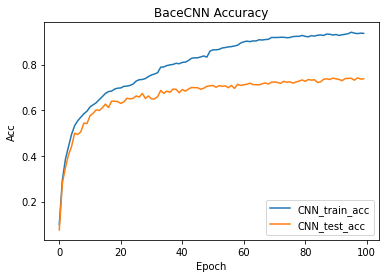

In [ ]:
model_trian_acc = []
model_test_acc = []
def Get_acc2(model='basecnn'):
  logFile = r'/content/drive/MyDrive/3dgcn/classification/record_' + model + '.log'
  text = ''
  file = open(logFile)
  for line in file:
      text += line
  file.close()

  train_acc_str = re.findall('= Epoch .*Train Acc:\s(.*)\s\|\sTest Loss.*',text)
  trian_acc = [float(x) for x in train_acc_str]
  test_acc_str = re.findall('= Epoch .*Test Acc:\s(.*)\s\|\sBest Acc.*',text)
  test_acc = [float(x) for x in test_acc_str]

  return trian_acc, test_acc

model_trian_acc, model_test_acc = Get_acc2('basecnn')
plt.figure()
plt.title('BaceCNN Accuracy')
plt.plot(model_trian_acc, label='CNN_train_acc')
plt.plot(model_test_acc, label='CNN_test_acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend(loc='lower right')
plt.show()